In [1]:
''' clear all variables '''
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


In [2]:
## Packages

In [3]:
import numpy as np
import math
from scipy import misc
import matplotlib.pyplot as plt
import time
from __future__ import print_function

from numpy.random import random_integers, randint, sample
import random as rnd

%matplotlib inline

## Getting the image

In [4]:
plt.gray()

## Getting the noisy image

### Test : about how to generate the noisy image

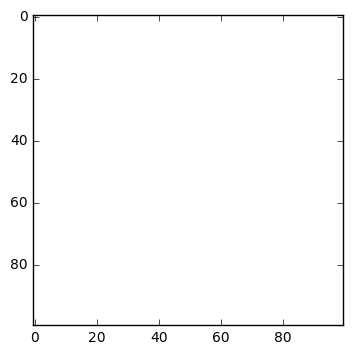

In [5]:
import numpy as np
img = np.zeros((100,100),dtype=np.uint8)
img_size = img.shape[0]*img.shape[1]
img[:] = 255
plt.imshow(img, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)
plt.show()

In [6]:
print("Number of pixels in the image: %s" %(img_size))
PropObserved = 0.3
NrandomPoints = int(np.round((1-PropObserved)*img_size, 0))
print("Number of observed points in the noisy image: %.1f%% " %(100*PropObserved))

Number of pixels in the image: 10000
Number of observed points in the noisy image: 30.0% 


#### Method 1

In [7]:
Xs = randint(0, img.shape[0], NrandomPoints)
Ys = randint(0, img.shape[1], NrandomPoints)
# tmp = random_noise(ascent, amount=0.0001)
# plt.imshow(tmp)
# plt.show()

Noisy_img = img.copy()
Noisy_img[Xs, Ys] = 0

1-float(np.sum(Noisy_img==0))/img_size

0.49970000000000003

#### Method 2

In [8]:
import random as rnd

idx = np.array([], dtype=np.int8).reshape(0,2)

for i in range(img.shape[1]):
    a = np.column_stack((np.ones(img.shape[0], dtype=np.int8)*i, np.arange(img.shape[0])))
    idx = np.concatenate((idx, a))
    
np.random.shuffle(idx)

Z = idx[rnd.sample(range(img_size), NrandomPoints),:]
[Xs, Ys] = Z.T

Noisy_img2 = img.copy()
Noisy_img2[Xs, Ys] = 0

1-float(np.sum(Noisy_img2==0))/img_size

0.30000000000000004

In [9]:
import random as rnd

def noise(X, PropObserved):
    '''Returns a noisy version of X given a proportion of observed data'''
    
    if len(X.shape) == 2:
        n, m = X.shape
    else:
        n, m, p = X.shape
        
    X_size = n*m
    NrandomPoints = int(np.round((1-PropObserved)*X_size, 0))
    
    Xs = np.zeros(NrandomPoints)
    Ys = np.zeros(NrandomPoints)
    
    idx = np.array([], dtype=np.int8).reshape(0,2)
    for i in range(n):
        a = np.column_stack((np.ones(m, dtype=np.int8)*i, np.arange(m)))
        idx = np.concatenate((idx, a))

    np.random.shuffle(idx)

    Z = idx[rnd.sample(range(X_size), NrandomPoints),:]
    [Xs, Ys] = Z.T
    
    NoisyX = X.copy()
    if len(X.shape) == 2:
        NoisyX[Xs, Ys] = 0
    else:
        NoisyX[Xs, Ys, :] = 0
    
    return(NoisyX)

C:\Program Files\Anaconda2\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


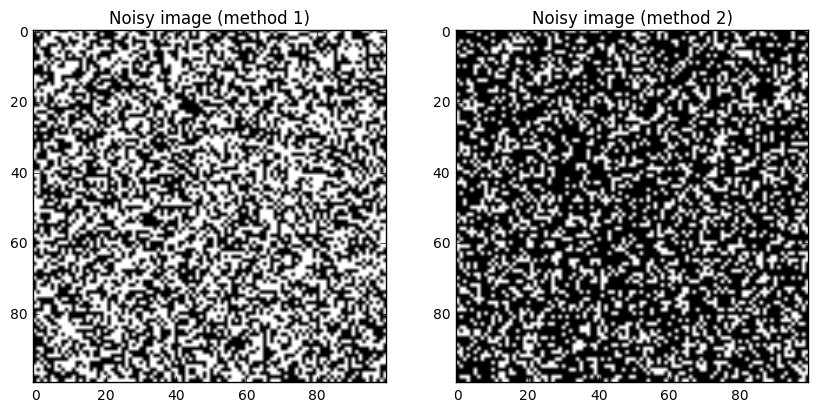

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))

ax1.imshow(Noisy_img)
ax1.set_title("Noisy image (method 1)")

ax2.imshow(Noisy_img2)
ax2.set_title("Noisy image (method 2)")

f.subplots_adjust(hspace=0)
f.show()

### Toy dataset

#### Image 1 (black and white): "ascent"

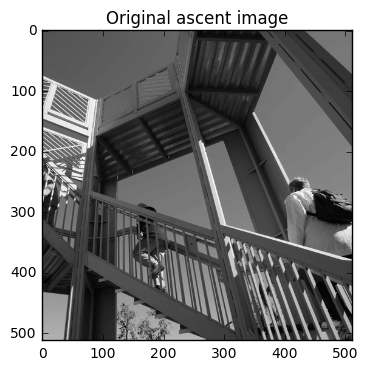

In [11]:
ascent = misc.ascent()
plt.imshow(ascent)
plt.title("Original ascent image")
plt.show()

In [12]:
print("Number of pixels in the image: %s" %(ascent.size))
PropObserved = 0.3
NrandomPoints = int(np.round((1-PropObserved)*ascent.size, 0))
print("Number of observed points in the noisy image: %.1f%% " %(100*PropObserved))

Number of pixels in the image: 262144
Number of observed points in the noisy image: 30.0% 


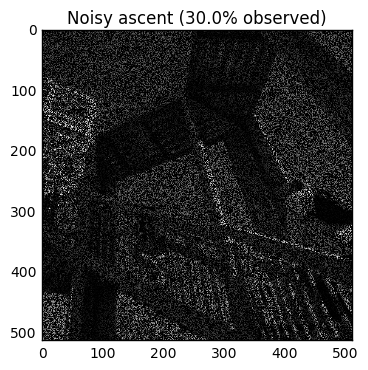

In [13]:
Noisyascent = noise(ascent, PropObserved)
plt.imshow(Noisyascent)
plt.title("Noisy ascent (%.1f%% observed)" %(100*PropObserved))
plt.show()

#### Image 2  (colored): "racoon"

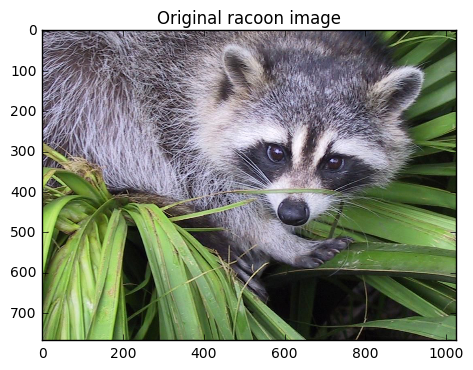

In [14]:
racoon = misc.face()
plt.imshow(racoon)
plt.title("Original racoon image")
plt.show()

In [15]:
print("Number of pixels in the image: %s" %(racoon.size))
PropObserved = 0.3
NrandomPoints = int(np.round((1-PropObserved)*racoon.size, 0))
print("Number of observed points in the noisy image: %.1f%% " %(100*PropObserved))

Number of pixels in the image: 2359296
Number of observed points in the noisy image: 30.0% 


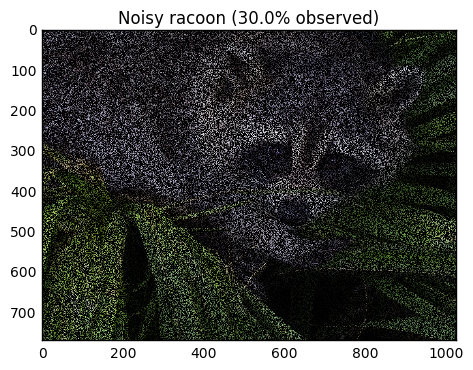

In [17]:
Noisyracoon = noise(racoon, PropObserved)
plt.imshow(Noisyracoon)
plt.title("Noisy racoon (%.1f%% observed)" %(100*PropObserved))
plt.show()

## Svd

In [18]:
from numpy.linalg import svd

In [19]:
def project(X, Z):
    ''' project X on the observable space of Z, namely every (i,j) where Z[i,j]<>0 '''
    Y = X.copy()
    Y[Z==0] = 0
    return Y

def project_orth(X, Z):
    ''' project X on the unobservable space of Z, namely every (i,j) where Z[i,j]=0 '''
    Y = X.copy()
    Y[Z>0] = 0
    return Y

In [20]:
def myLoss(X, Y):
    """
    Loss function to be minimized
    X is the original image
    Y is the predicted image
    """
    return np.linalg.norm(project(X) - project(Y))**2

In [21]:
def myMax(X, a):
    """
    Takes the max between 0 and X_i,j - a within X
    """
    X-=a
    X[X < 0] = 0
    return X

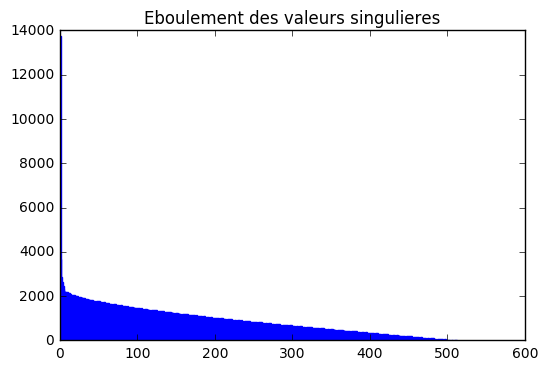

In [22]:
# We first do some sort of warm starting
prediction = Noisyascent + project(np.random.rand(Noisyascent.shape[0], Noisyascent.shape[1]),Noisyascent)

# In this case we will only work with the first singular value
# we know the solution to the minimization problem hence we dont need to use the loss

u, s, v = svd(Noisyascent)

plt.bar(np.arange(0,512,1), s, color="blue", edgecolor="blue")
plt.title("Eboulement des valeurs singulieres")
plt.show()

### Soft Impute

In [23]:
def soft_threshold_svd(X, lbda):
    
    n, m = X.shape
    r = min(n, m)
    u_tmp, s_tmp, v_tmp = svd(X, full_matrices=True)
    s = np.zeros((n,m), dtype=float)
    s[:r, :r] = np.diag(s_tmp)
    prediction = np.dot(u_tmp, myMax(s, lbda)).dot(v_tmp)
    return(prediction)

def pen_loss(Noisyascent, Z, lbda):
    loss = 1./2*np.linalg.norm(Noisyascent - project(Noisyascent, Z))**2 + lbda*np.linalg.norm(Z, 'nuc')
    return(loss)

In [25]:
def soft_impute(X, true_X, Total_runs=5, Max_iterate=20, epsilon = 0.01, verbose=True, plot_loss=True, plot_pred=True):

    #X = 255*np.ones_like(X) - X
    #true_X = 255*np.ones_like(true_X) - true_X
    
    if len(X.shape)==2:
        BW = True
        ' black-and-white image '
        n, m = X.shape
        u, s, v = svd(X, full_matrices=True)
        ''' regularization path '''
        lbda0 = s[0]
        lbda_seq = np.exp(np.linspace(start=np.log(lbda0), stop=np.log(1.) , num=Total_runs))
        ''' Initialization '''
        X_pred = np.zeros((n, m))
        Z_old = np.zeros((n, m))
        Z_new = np.zeros((n, m))
    else:
        BW = False
        'colored RGB image '
        n, m, p = X.shape
        lbda_seq = []
        for j in range(p):
            u, s, v = svd(X[:,:,j], full_matrices=True)
            ''' regularization path '''
            lbda0 = s[0]
            lbda_seq.append(np.exp(np.linspace(start=np.log(lbda0), stop=np.log(1.) , num=Total_runs)))
        ''' Initialization '''
        X_pred = np.zeros((n, m, p))
        Z_old = np.zeros((n, m, p))
        Z_new = np.zeros((n, m, p))
    
    start_time = time.time()

    improv_list = []
    distance_list = []
    recovery_list = []
    
    improvement = 1000
    
    #distance = np.sum([np.linalg.norm(true_X[:,:,j] - Z_old[:,:,j]) for j in range(p)])
    #recovery = np.sum([np.linalg.norm(project(true_X[:,:,j] - Z_old[:,:,j], X[:,:,j])) for j in range(p)])
    
    if verbose:
        print("i", "iterate", "distance", "improvement", sep='\t')
        
    for i in range(Total_runs): 

        iterate = 0
        #print("improvement %s " %improvement)
        improvement = 1000
        
        while np.logical_and(iterate < Max_iterate, improvement > epsilon):
            
            #print("%d, %d : %s" %(i,iterate,np.sum([np.linalg.norm(Z_old[:,:,j]) for j in range(p)])))
        
            if BW:
                Z_new = soft_threshold_svd(X + project_orth(Z_old, X), lbda_seq[i])
            else:
                for j in range(p):
                    Z_new[:,:,j] = soft_threshold_svd(X[:,:,j] + project_orth(Z_old[:,:,j], X[:,:,j]), lbda_seq[j][i])
            
            ' metrics '
            ' distance to the true image '
            if BW:
                distance = np.linalg.norm(true_X - Z_old)
                recovery = np.linalg.norm(project(true_X - Z_old, X))
                if np.logical_or(i>2, iterate>0):
                    if np.linalg.norm(Z_old) == 0:
                        improvement = 1000
                    else:
                        improvement = (np.linalg.norm(Z_new - Z_old)/np.linalg.norm(Z_old))**2
            else:
                distance = np.sum([np.linalg.norm(true_X[:,:,j] - Z_old[:,:,j]) for j in range(p)])
                recovery = np.sum([np.linalg.norm(project(true_X[:,:,j] - Z_old[:,:,j], X[:,:,j])) for j in range(p)])
                if np.logical_or(i>0, iterate>0):
                    #print(np.sum([np.linalg.norm(Z_new[:,:,j] - Z_old[:,:,j]) for j in range(p)]))
                    #print(np.sum([np.linalg.norm(Z_old[:,:,j]) for j in range(p)]))
                    if np.sum([np.linalg.norm(Z_old[:,:,j]) for j in range(p)]) == 0:
                        improvement = 0
                    else:
                        improvement = (np.sum([np.linalg.norm(Z_new[:,:,j] - Z_old[:,:,j]) for j in range(p)])/np.sum([np.linalg.norm(Z_old[:,:,j]) for j in range(p)]))**2
                        
            #print(distance, recovery)
            
                                                  

            improv_list.append(improvement)
            distance_list.append(distance)
            recovery_list.append(recovery)
            ' update '
            Z_old = Z_new.copy()
            iterate+=1

        #stackpred[:,:,i] = Z_new
        
        if verbose:
            print(i, iterate, round(distance,2), round(improvement,6), sep='\t')
         
    X_pred = Z_new.astype(np.uint8)
    
    end_time = time.time()
    time_delta = end_time - start_time
    
    print("Running time: %.2f seconds" %time_delta)
    
    if plot_loss:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
        ax1.set_title("improvement of the penalized loss")
        ax1.semilogy(improv_list, color="orange", linewidth=2)
        ax2.set_title("evolution of the distance to the true image")
        ax2.semilogy(distance_list, color="orange", linewidth=2)
        ax3.set_title("evolution of the recovery of the true image")
        ax3.plot(recovery_list, color="orange", linewidth=2)
        f.show()
    
    if plot_pred:
        ' combination of the input noisy image and optimal completed part '
        if BW:
            BestPred = X + project_orth(X_pred, X)
        else:
            BestPred = np.zeros((n, m, p))
            for j in range(p):
                BestPred[:,:,j] = X[:,:,j] + project_orth(X_pred[:,:,j], X[:,:,j])
            BestPred = BestPred.astype(np.uint8)

        
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 60))

        ax1.imshow(true_X)
        ax1.set_title("Original image")

        ax2.imshow(X)
        ax2.set_title("Noisy image (%.1f%% observed) - distance = %.f" %(100*PropObserved, np.linalg.norm(X - true_X)))

        ax3.imshow(X_pred)
        ax3.set_title("Prediction - distance = %.2f" %(np.linalg.norm(true_X - X_pred)))

        ax4.imshow(BestPred)
        ax4.set_title("Best prediction - distance = %.2f" %(np.linalg.norm(true_X - BestPred)))

        f.subplots_adjust(hspace=0)
        f.show()
        
    return(X_pred)

i	iterate	distance	improvement
0	20	109642.08	1000.0
1	20	61053.59	0.00058
2	2	59561.21	0.0
Running time: 73.13 seconds


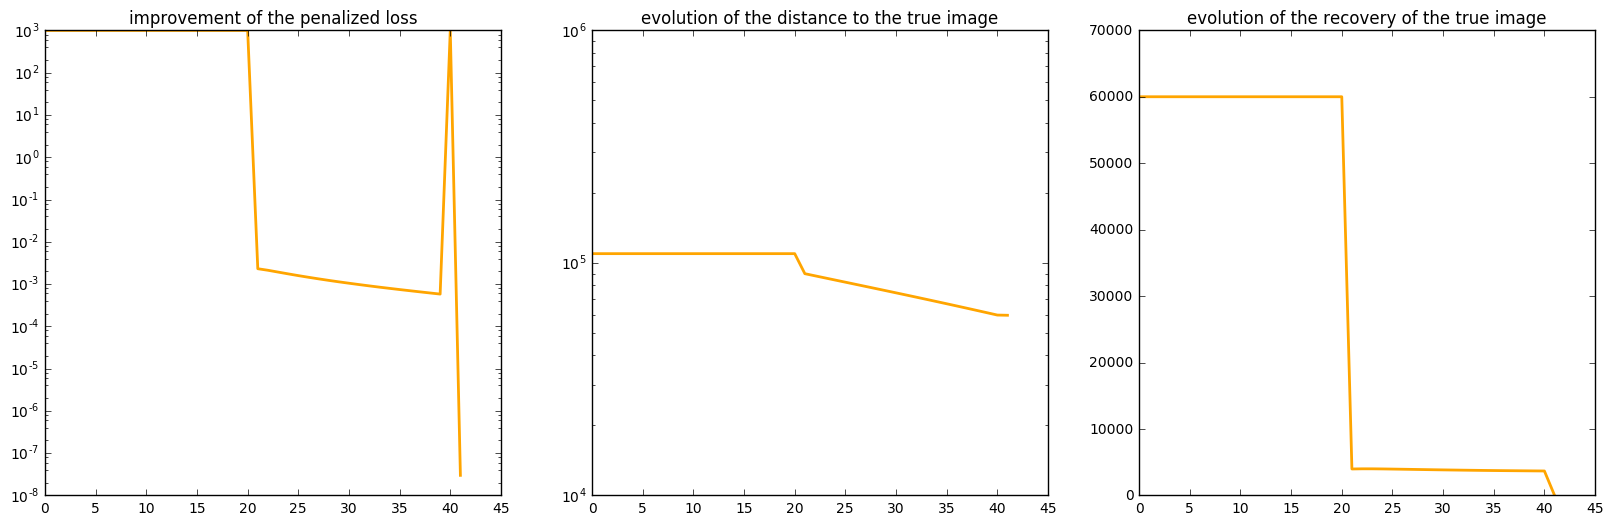

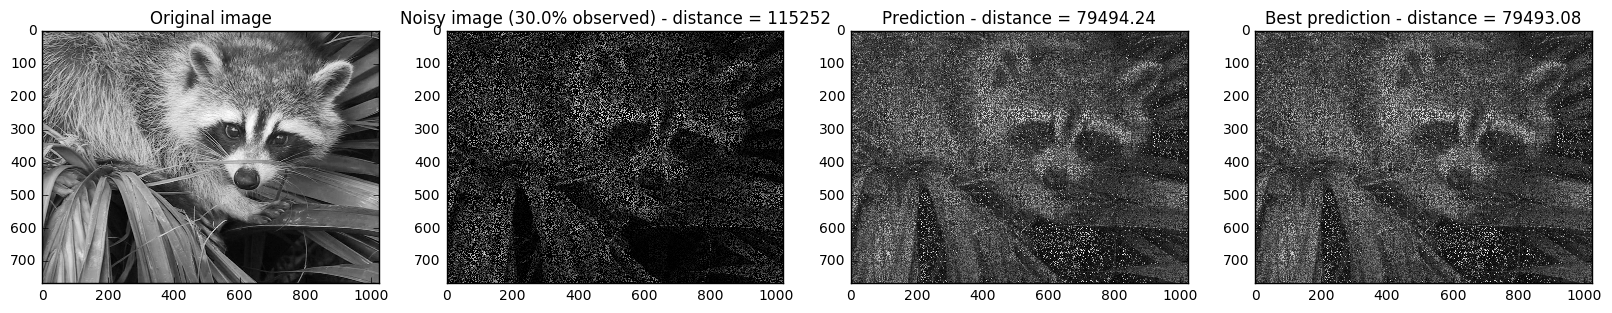

In [26]:
predascent = soft_impute(Noisyracoon[:,:,0], racoon[:,:,0], Total_runs=3, epsilon=1e-6, verbose=True, plot_loss=True, plot_pred=True)

In [28]:
predracoon = racoon.copy()
predracoon[:,:,0] = predracoon_R
predracoon[:,:,1] = predracoon_G
predracoon[:,:,2] = predracoon_B

plt.imshow(predracoon)
plt.show()
plt.imshow(Noisyracoon + project_orth(predracoon, Noisyracoon))
plt.show()

print(np.linalg.norm(racoon - predracoon))
print(np.linalg.norm(racoon - Noisyracoon))
print(np.linalg.norm(racoon - (Noisyracoon + project_orth(predracoon, Noisyracoon))))

NameError: name 'predracoon_R' is not defined

### Hard Impute

In [ ]:
def H(X, r):
    """
    This function performs the rank r truncated SVD approximation of X.
    """
    u, s, v = svd(X)
    u = u[:,:r]
    v = v[:r,:]
    s = s[:r]
    return u, s, v

In [ ]:
def hard_impute(Total_runs=5, Max_iterate=20, epsilon=0.01, X=Noisyascent, rank=20, verbose=True, graph=True):
    
    start_time = time.time()
    
    u, s, v = svd(X)

    improv_list = []
    distance_list = []

    stackpred = np.zeros((ascent.shape[0], ascent.shape[1], Total_runs))
    Z_old = np.zeros((X.shape[0], X.shape[1]))

    if verbose:
        print("i", "iterate", "distance", "improvement", sep='\t')
    
    for i in range(s.shape[0])[0:Total_runs]: 
        
        distance = np.linalg.norm(ascent - Z_old)
        iterate = 0
        improvement = 1000

        while np.logical_and(iterate < Max_iterate, improvement > epsilon): 
            # Here we consider the truncated SVD approximation of the input Matrix
            tmp = H(Noisyascent + project_orth(Z_old, X),rank) 
            Z_new = tmp[0].dot(np.diag(tmp[1])).dot(tmp[2])
            ' metrics '
            ' distance to the true image '
            distance = np.linalg.norm(ascent - Z_new)
            ' improvement of Z_new compared to Z_old '
            if np.linalg.norm(Z_old) == 0:
                improvement = 0
            else:
                improvement = (np.linalg.norm(Z_new - Z_old)/np.linalg.norm(Z_old))**2
            
            improv_list.append(improvement)
            distance_list.append(distance)
            ' update '
            Z_old = Z_new
            iterate+=1

        stackpred[:,:,i] = Z_new
        
        if verbose:
            print(i, iterate, round(distance,2), round(improvement,3), sep='\t')
            
    end_time = time.time()
    time_delta = end_time - start_time
    
    print("Running time: %.2f seconds" %time_delta)
   
    if graph:
        plt.title("improvement of the penalized loss")
        plt.plot(improv_list, color="orange", linewidth=2)
        plt.show()
        plt.title("evolution of the distance to the true image")
        plt.plot(distance_list, color="orange", linewidth=2)
        plt.show()
    
    return(stackpred)

In [ ]:
stackpred = hard_impute(Total_runs=20, epsilon=0.00001, verbose=False, graph=True)

In [ ]:
' combination of the input noisy image and optimal completed part '
BestPred = Noisyascent + project_orth(stackpred[:,:,-1])

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 60))

ax1.imshow(ascent)
ax1.set_title("Original image")

ax2.imshow(Noisyascent)
ax2.set_title("Noisy image (%.1f%% observed) - distance = %.f" %(100*PropObserved, np.linalg.norm(Noisyascent - ascent)))

ax3.imshow(stackpred[:,:,-1])
ax3.set_title("Prediction - distance = %.f" %(np.linalg.norm(ascent - stackpred[:,:,-1])))

ax4.imshow(BestPred)
ax4.set_title("Best prediction - distance = %.f" %(np.linalg.norm(ascent - BestPred)))

f.subplots_adjust(hspace=0)
f.show()

### MMMF

For the computation, one can see that Hastie consider the rank-r approximation (r truncated solution) Z svd and then write Z as the dot product of two matrices A and B

In [29]:
def H(X, r):
    """
    This function performs the rank r truncated SVD approximation of X.
    """
    u, s, v = svd(X)
    u = u[:,:r]
    v = v[:r,:]
    s = s[:r]
    return u, s, v

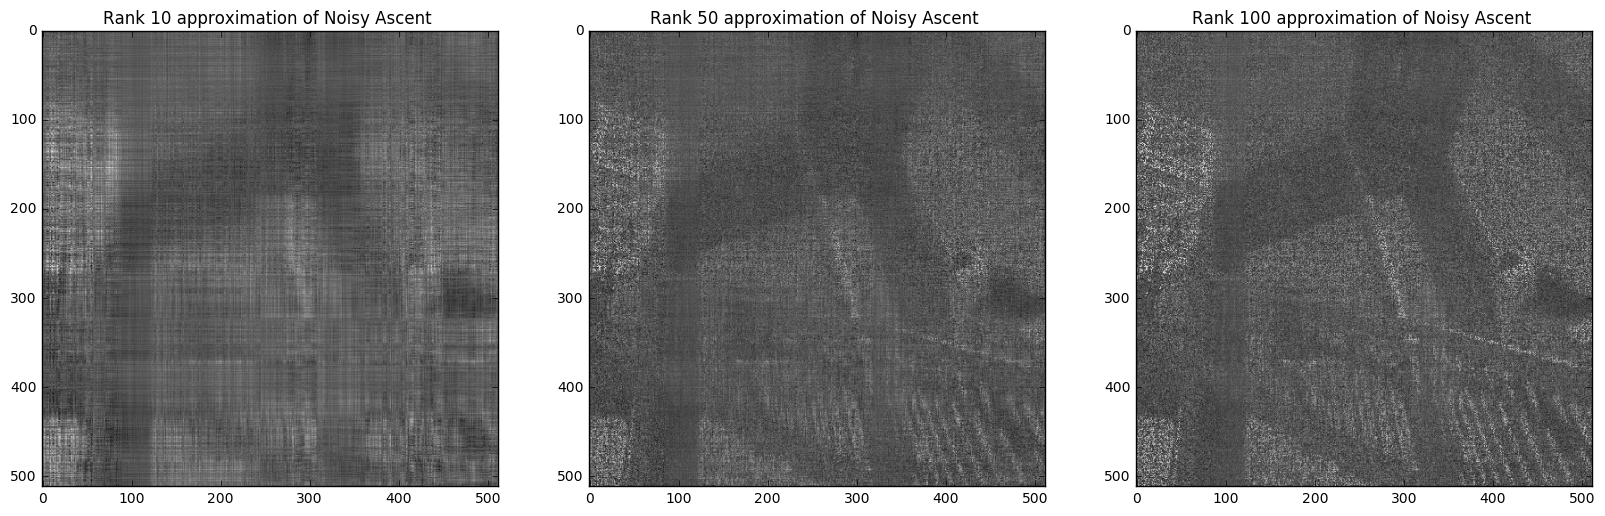

In [30]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 60))

u, s, v = H(Noisyascent, 10)

ax1.imshow(np.dot(u, np.diag(s)).dot(v))
ax1.set_title("Rank 10 approximation of Noisy Ascent ")

u, s, v = H(Noisyascent, 50)

ax2.imshow(np.dot(u, np.diag(s)).dot(v))
ax2.set_title("Rank 50 approximation of Noisy Ascent ")

u, s, v = H(Noisyascent, 100)

ax3.imshow(np.dot(u, np.diag(s)).dot(v))
ax3.set_title("Rank 100 approximation of Noisy Ascent ")

plt.show()

In [31]:
def MMMF(Total_runs=10, lbda=10, rank=20, epsilon = 0.01, X=Noisyascent, verbose=True, graph=True):

    modulo = 100
    
    start_time = time.time()
    
    n, m = X.shape
    
    ' We initialize matrices A and B '
    ' WARM START given by : ? '
    u, s, v = H(X, rank) #u.shape (512L, 20L) #v.shape (20L, 512L)
    D = np.diag(s) 
    
    A = np.dot(u, D)  #(512L, 20L)
    B = np.dot(v.T,D).T #(512L, 20L)
    
    A_new = A
    B_new = B
    
    #A = 255 * np.random.rand(m, n_factors) 
    #B = 255 * np.random.rand(n_factors, n)
    
    u, s, v = svd(X)

    improv_list = []
    distance_list = []

    stackpred = np.zeros((ascent.shape[0], ascent.shape[1]))
    Z_old = A.dot(B)
    
    distance = np.linalg.norm(ascent - Z_old)
    iterate = 0
    improvement = 1000
    
    if verbose:
        print("iterate", "distance", "improvement", sep='\t')

    while np.logical_and(iterate < Total_runs, improvement > epsilon): 
        
        A = np.linalg.solve(np.dot(B, B.T) + lbda * np.eye(rank), 
                        np.dot(B, X.T)).T
        B = np.linalg.solve(np.dot(A.T, A) + lbda * np.eye(rank),
                        np.dot(A.T, X))
        
        Z_new = A.dot(B)
        distance = np.linalg.norm(ascent - Z_new)
        ' improvement of Z_new compared to Z_old '
        if np.linalg.norm(Z_old) == 0:
            improvement = 0
        else:
            improvement = (np.linalg.norm(Z_new - Z_old)/np.linalg.norm(Z_old))**2

        improv_list.append(improvement)
        distance_list.append(distance)
        ' update '
        Z_old = Z_new
        
        if np.logical_and(verbose, iterate%modulo==0):
            print(iterate, round(distance,2), round(improvement,6), sep='\t')
            
        iterate+=1
        
    stackpred = Z_new
            
    end_time = time.time()
    time_delta = end_time - start_time
    
    print("Running time: %.2f seconds" %time_delta)
    
    if graph:
        plt.title("improvement of the penalized loss")
        plt.plot(improv_list, color="orange", linewidth=2)
        plt.show()
        plt.title("evolution of the distance to the true image")
        plt.plot(distance_list, color="orange", linewidth=2)
        plt.show()
    
    return(stackpred)


iterate	distance	improvement
0	44962.03	0.999907
100	41904.64	0.0
200	41898.74	0.0
Running time: 14.10 seconds


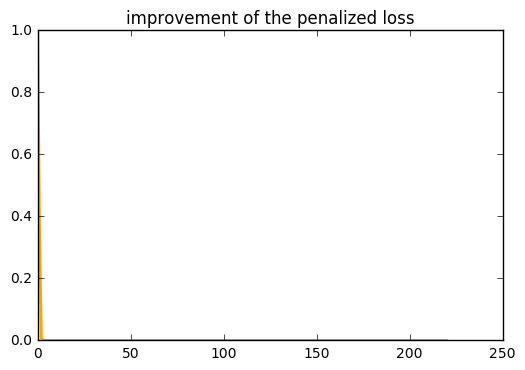

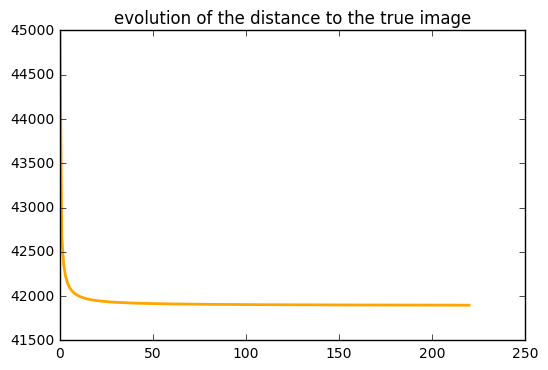

In [32]:
stackpred = MMMF(Total_runs=1000, lbda=1, rank=200, epsilon=1e-10)

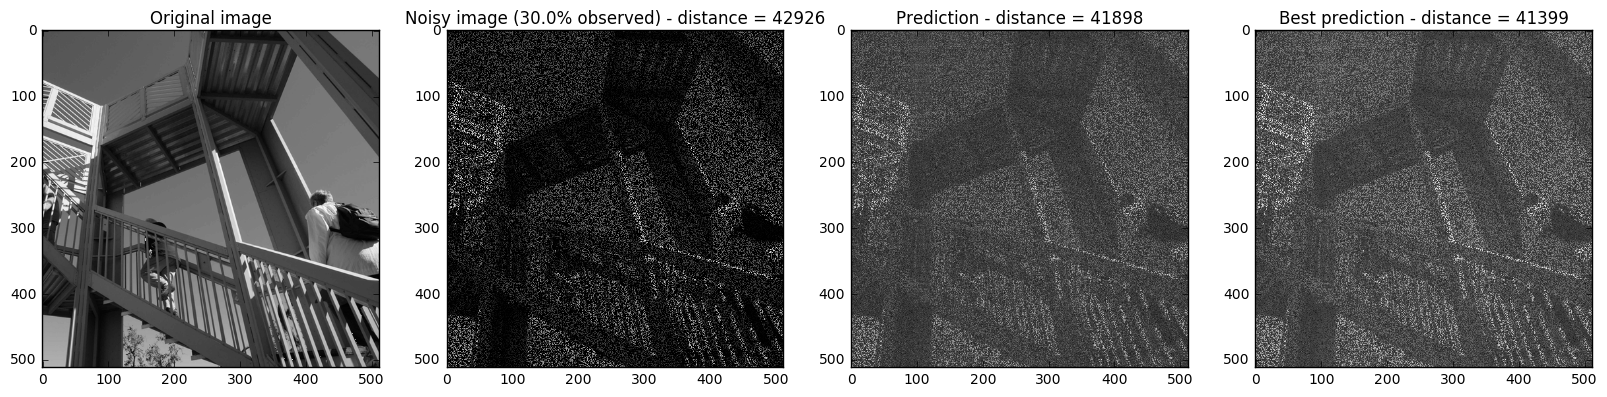

In [37]:
' combination of the input noisy image and optimal completed part '
BestPred = Noisyascent + project_orth(stackpred, Noisyascent)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 60))

ax1.imshow(ascent)
ax1.set_title("Original image")

ax2.imshow(Noisyascent)
ax2.set_title("Noisy image (%.1f%% observed) - distance = %.f" %(100*PropObserved, np.linalg.norm(Noisyascent - ascent)))

ax3.imshow(stackpred)
ax3.set_title("Prediction - distance = %.f" %(np.linalg.norm(ascent - stackpred)))

ax4.imshow(BestPred)
ax4.set_title("Best prediction - distance = %.f" %(np.linalg.norm(ascent - BestPred)))

f.subplots_adjust(hspace=0)
f.show()

In [34]:
# Check https://arxiv.org/pdf/1410.2596.pdf page 8 and 10

def softImpute_ALS(X, r, lbda=1., Max_iter=20):
    #warm start
    u, s, v = H(X,r) #u.shape (512L, 20L) #v.shape (20L, 512L)
    D = np.diag(s) 
    
    A = np.dot(u, D)  #(512L, 20L)
    B = np.dot(v.T,D) #(512L, 20L)
    
    A_new = A
    B_new = B
    
    iter = 0

    while iter <= Max_iter:
        A = A_new #inutile pour la premiere iteration
        B = B_new #inutile pour la premiere iteration
        ReducedNoisyAscent = np.dot(u, np.diag(s)).dot(v)
        X_star = project(ReducedNoisyAscent, X) - project_orth(A.dot(B.T), X) + A.dot(B.T)

        B_tild = np.linalg.solve(D**2 + lbda*np.eye(len(s)), D.dot(u.T).dot(X_star)) # attention transposed

        BD = B_tild.T.dot(D) #(512L, 20L)

        u_tild, s2, v_tild = H(BD, r)   #il n'y a pas d'autre solution que H sinon dim pb
        # u_tild.shape (512L, 20L)
        # v_tild.shape (20L, 20L)
        D = np.diag(np.sqrt(s2))
        B_new = u_tild.dot(D)

        A_tild = X_star.dot(u_tild).dot(D).dot(np.linalg.inv(D**2 + lbda*np.eye(len(s)))) #from page 8
        # A_tild.shape (512L, 20L)
        AD = A_tild.dot(D)
        v_tild, s2, vv_tild = H(AD, r) #u_tild.shape (512L, 20L),v_tild.shape (20L, 20L)

        D = np.diag(np.sqrt(s2))
        A_new = np.dot(v_tild, D) #(512L, 20L)  
        iter+=1

    M = X.dot(v_tild)
    U, d, R = svd(M) #U.shape (512L, 512L) R.shape (20L, 20L)

    A = U.dot(X)
    B = R.T.dot(np.diag(d))
#     plt.imshow(A_new.dot(B_new.T))
    #Normalement A_new*B_new' est une bonne prediction
    output = A_new.dot(B_new.T)
    
    return A_new.dot(B_new.T)

In [35]:
pred = softImpute_ALS(Noisyascent, 20, Max_iter=1000)

In [ ]:
pred

In [ ]:
plt.imshow(Noisyascent+project_orth(pred))
plt.show()

In [40]:
def NMF(X, r, lbda=1., Max_iter=200, plot_loss=True, plot_pred=True, Xtrue=ascent):
    improv_list = []
    distance_list = []
    for i in range(Max_iter):
        W = np.random.randint(low=0,high=255,size=(X.shape[0], r))
        H = np.linalg.solve(W.T.dot(W), W.T.dot(X))
        H[H<0] = 0
        W = np.linalg.solve(H.dot(H.T), H.dot(X.T)).T
        W[W<0] = 0
#     print(i) 
#     print(W.dot(H).shape)
    
    Z_new = W.dot(H)
    Z_old = np.zeros_like(Z_new)
    distance = np.linalg.norm(Xtrue - Z_new)
    
    if np.linalg.norm(Z_old) == 0:
        improvement = 0
    else:
        improvement = (np.linalg.norm(Z_new - Z_old)/np.linalg.norm(Z_old))**2
    
    improv_list.append(improvement)
    distance_list.append(distance)
    
    Z_old = Z_new.copy()
    
    if plot_loss:
        plt.title("improvement of the penalized loss")
        plt.plot(improv_list, color="orange", linewidth=2)
        plt.show()
        plt.title("evolution of the distance to the true image")
        plt.plot(distance_list, color="orange", linewidth=2)
        plt.show() 
    
    if plot_pred:
        pass
    return W.dot(H)

In [ ]:
' combination of the input noisy image and optimal completed part '
BestPred = Noisyascent + project_orth(stackpred, Noisyascent)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 60))

ax1.imshow(ascent)
ax1.set_title("Original image")

ax2.imshow(Noisyascent)
ax2.set_title("Noisy image (%.1f%% observed) - distance = %.f" %(100*PropObserved, np.linalg.norm(Noisyascent - ascent)))

ax3.imshow(stackpred)
ax3.set_title("Prediction - distance = %.f" %(np.linalg.norm(ascent - stackpred)))

ax4.imshow(BestPred)
ax4.set_title("Best prediction - distance = %.f" %(np.linalg.norm(ascent - BestPred)))

f.subplots_adjust(hspace=0)
f.show()

By running the following code, the problem is to find the rank r to select (r << min(n, m)). There is a trade off between selecting a big r and having low iterations possible before obtaining a singular matrix or selecting a small r and not much improving the Noisy Image.

Since W is set at random, multiples attempt with the same r value may lead to different outcomes.

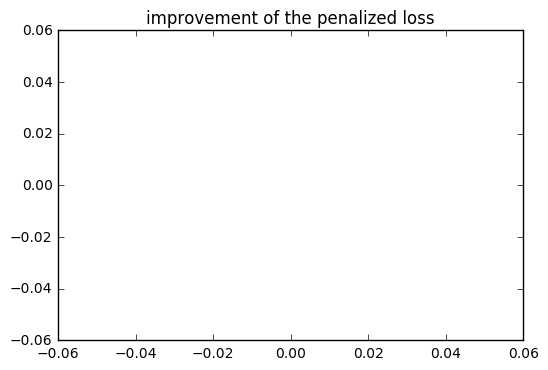

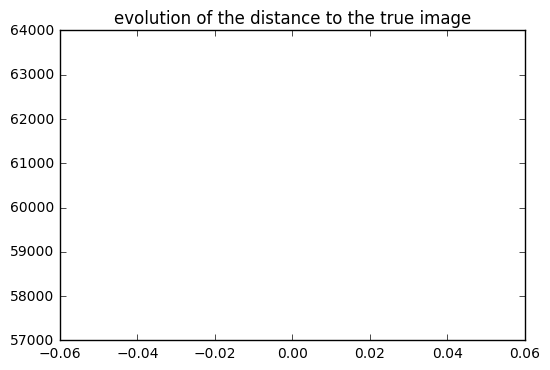

In [41]:
a = NMF(Noisyascent, 200)

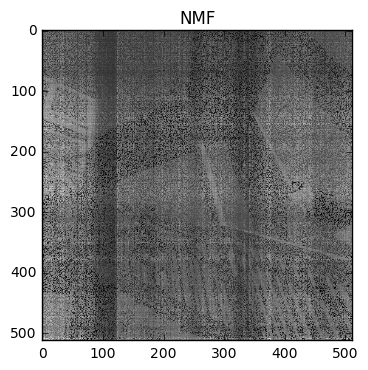

In [223]:
plt.imshow(Noisyascent + project_orth(a, Noisyascent))
plt.title("NMF")
plt.show()

In [ ]:
b = Noisyascent + project_orth(a)

In [ ]:
NMF(b, 10)

In [ ]:
plt.imshow(Noisyascent+project_orth(NMF(b, 50)))